In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import shutil
import random
import seaborn as sns
import datetime 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from keras.regularizers import l1, l2
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard

Using TensorFlow backend.


### Dataset2 - only pavements
#### Train data: negative = ~17k, positive = ~17k (2087 original images + data augmentation), validation = 25%
#### Test data: negative = 4345, positive = 521

In [3]:
# useful functions

def plot_cm(true,pred):
    cm=confusion_matrix(true,pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax=sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    ax.set(xlabel='Prediction', ylabel='Class')
    return ax
#plot_cm(test_ds.classes, test_predict_classes)

# plot train/val accuracy
def plot_accuracy(history):
    ax=plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')
#plot_accuracy(history)

# plot train/val recall
def plot_recall(history):
    ax=plt.figure()
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.title('Model Recall')
    plt.ylabel('recall')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')
#plot_accuracy(history)

# plot train/val recall
def plot_precision(history):
    ax=plt.figure()
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('Model Precision')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')
    
# plot train/val recall
def plot_loss(history):
    ax=plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')

# evaluate and plot ROC
def plot_roc(y_true, score, return_pos_rate=False):
    fpr, tpr, threshold=roc_curve(y_true,score)
    roc_auc=auc(fpr, tpr)
    ax=plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="best")
    if return_pos_rate==True:
        return ax, pd.DataFrame({'threshold':threshold, 'True Positive Rate':tpr, 'False Positive Rate':fpr})
    
#q=plot_roc(test_ds.classes, test_predict)

def ImageGenerators(path_train, path_test):
    
    train_datagen=ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25)

    train_ds=train_datagen.flow_from_directory(
        path_train,  
        class_mode='binary',
        subset="training", 
        seed=11, 
        target_size=(img_height, img_width), 
        batch_size=batch_size,
        classes=['Non-cracked','Cracked']
    )

    val_datagen=ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25)

    val_ds=val_datagen.flow_from_directory(
        path_train,  
        class_mode='binary',
        subset="validation", 
        seed=11, 
        target_size=(img_height, img_width), 
        batch_size=batch_size,
        classes=['Non-cracked','Cracked']
    )

    test_datagen=ImageDataGenerator(rescale=1./255)

    test_ds=test_datagen.flow_from_directory(
        path_test, 
        class_mode='binary',
        seed=11, 
        target_size=(img_height, img_width), 
        batch_size=batch_size,
        classes=['Non-cracked','Cracked'],
        shuffle=False)
    return train_ds, val_ds, test_ds

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy= []
        self.precision=[]
        self.recall=[]

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.precision.append(logs.get('precision'))
        self.recall.append(logs.get('recall'))
loss_history = LossHistory()

In [4]:
# Image Generators
batch_size = 128
img_height = 256 #224
img_width = 256 #224
root='/storage/Crack_detection/Dataset2/Dataset2'

'''decks_train=os.path.join(root, 'Decks','Train')
decks_test=os.path.join(root, 'Decks','Test')
decks_train, decks_val, decks_test=ImageGenerators(decks_train, decks_test)

walls_train=os.path.join(root, 'Walls','Train')
walls_test=os.path.join(root, 'Walls','Test')
walls_train, walls_val, walls_test=ImageGenerators(walls_train, walls_test)
'''
pavements_train=os.path.join(root, 'Pavements','Train')
pavements_test=os.path.join(root, 'Pavements','Test')
pavements_train, pavements_val, pavements_test=ImageGenerators(pavements_train, pavements_test)

Found 26077 images belonging to 2 classes.
Found 8692 images belonging to 2 classes.
Found 4866 images belonging to 2 classes.


## CNN Model, 2 CNN layers w/ dropout - no BatchNorm

In [ ]:
model_2cnn_dp7=Sequential()

model_2cnn_dp7.add(Conv2D(8, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(img_height, img_width, 3)))
model_2cnn_dp7.add(MaxPool2D(pool_size=(2,2)))

model_2cnn_dp7.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation='relu'))
model_2cnn_dp7.add(MaxPool2D(pool_size=(2,2)))

model_2cnn_dp7.add(Flatten())
model_2cnn_dp7.add(Dense(100, activation='relu'))
model_2cnn_dp7.add(Dropout(0.7))

model_2cnn_dp7.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_2cnn_dp7.build(input_shape=(img_height, img_width, 3))
model_2cnn_dp7.summary()

model_2cnn_dp7.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy', 'Recall', 'Precision'])

history_2cnn_dp7=model_2cnn_dp7.fit(
pavements_train,
validation_data=pavements_val, 
epochs=10
)

model_2cnn_dp7.save('/Crack_detection/Crack_detection/2CNN_dp7_model_012021.h5')
plot_loss(history_2cnn_dp7)
plot_accuracy(history_2cnn_dp7)
plot_precision(history_2cnn_dp7)
plot_recall(history_2cnn_dp7)

test_predict=model_2cnn_dp7.predict(pavements_test)
test_predict_classes=[1 if i>0.5 else 0 for i in test_predict]
plt.figure()
plot_cm(pavements_test.classes, test_predict_classes)

## CNN Model, 3 CNN layers - no BatchNorm

In [4]:
model_3cnn=Sequential()

model_3cnn.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(img_height, img_width, 3)))
#model_3cnn.add(BatchNormalization())
model_3cnn.add(MaxPool2D(pool_size=(2,2)))

model_3cnn.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu'))
#model_3cnn.add(BatchNormalization())
model_3cnn.add(MaxPool2D(pool_size=(2,2)))

model_3cnn.add(Conv2D(64, kernel_size=(5,5), strides=(1,1), activation='relu'))
#model_3cnn.add(BatchNormalization())
model_3cnn.add(MaxPool2D(pool_size=(2,2)))

model_3cnn.add(Flatten())
model_3cnn.add(Dense(100, activation='relu'))
#model_3cnn.add(Dropout(0.6))

model_3cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_3cnn.build(input_shape=(img_height, img_width, 3))
model_3cnn.summary()

model_3cnn.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy', 'Recall', 'Precision'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 53824)             0

In [5]:
history_3cnn=model_3cnn.fit(
pavements_train,
validation_data=pavements_val, 
epochs=10
)

Epoch 1/10
204/204 [==============================] - 646s 3s/step - loss: 0.7226 - accuracy: 0.6091 - recall: 0.6517 - precision: 0.6029 - val_loss: 0.6108 - val_accuracy: 0.6897 - val_recall: 0.6625 - val_precision: 0.7007
Epoch 2/10
204/204 [==============================] - 668s 3s/step - loss: 0.2738 - accuracy: 0.8884 - recall: 0.8737 - precision: 0.9012 - val_loss: 0.5789 - val_accuracy: 0.6997 - val_recall: 0.7589 - val_precision: 0.6787
Epoch 3/10
204/204 [==============================] - 628s 3s/step - loss: 0.1903 - accuracy: 0.9240 - recall: 0.9108 - precision: 0.9349 - val_loss: 0.7825 - val_accuracy: 0.7629 - val_recall: 0.5551 - val_precision: 0.9500
Epoch 4/10
204/204 [==============================] - 629s 3s/step - loss: 0.1315 - accuracy: 0.9503 - recall: 0.9417 - precision: 0.9596 - val_loss: 1.1047 - val_accuracy: 0.7471 - val_recall: 0.5017 - val_precision: 0.9855
Epoch 5/10
204/204 [==============================] - 627s 3s/step - loss: 0.1044 - accuracy: 0.9625

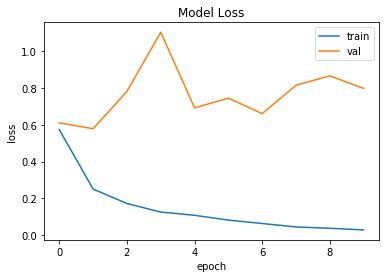

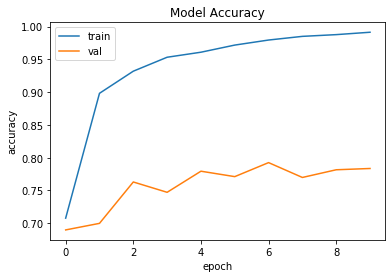

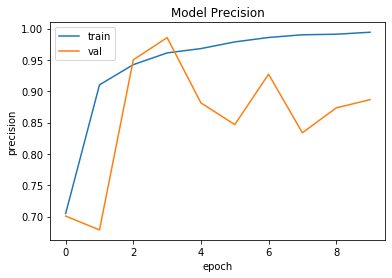

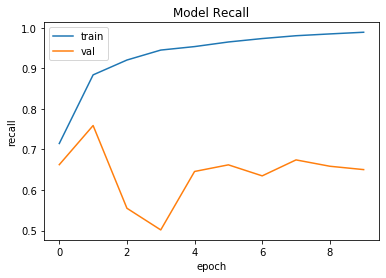

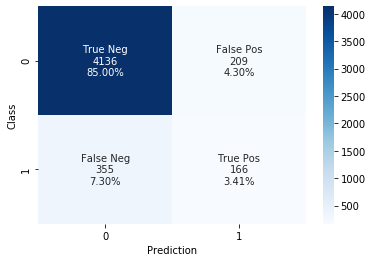

In [7]:
model_3cnn.save('/Crack_detection/Crack_detection/3CNN_model_012021.h5')
plot_loss(history_3cnn)
plot_accuracy(history_3cnn)
plot_precision(history_3cnn)
plot_recall(history_3cnn)

test_predict=model_3cnn.predict(pavements_test)
test_predict_classes=[1 if i>0.5 else 0 for i in test_predict]
plt.figure()
plot_cm(pavements_test.classes, test_predict_classes)

## CNN Model, 3 CNN layers w/ dropout - no BatchNorm

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 58, 58, 64)        51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 53824)            

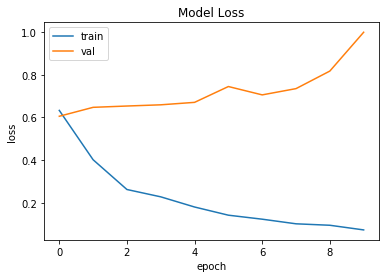

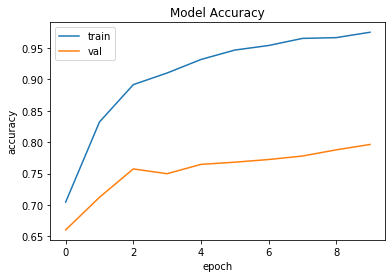

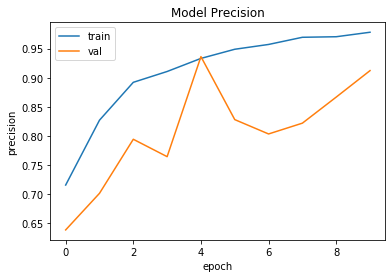

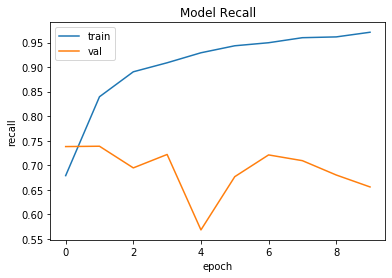

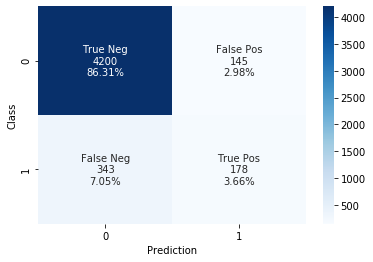

In [11]:
model_3cnn_dp7=Sequential()

model_3cnn_dp7.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(img_height, img_width, 3)))
model_3cnn_dp7.add(MaxPool2D(pool_size=(2,2)))

model_3cnn_dp7.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu'))
model_3cnn_dp7.add(MaxPool2D(pool_size=(2,2)))

model_3cnn_dp7.add(Conv2D(64, kernel_size=(5,5), strides=(1,1), activation='relu'))
model_3cnn_dp7.add(MaxPool2D(pool_size=(2,2)))

model_3cnn_dp7.add(Flatten())
model_3cnn_dp7.add(Dense(100, activation='relu'))
model_3cnn_dp7.add(Dropout(0.7))

model_3cnn_dp7.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_3cnn_dp7.build(input_shape=(img_height, img_width, 3))
model_3cnn_dp7.summary()

model_3cnn_dp7.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy', 'Recall', 'Precision'])

history_3cnn_dp7=model_3cnn_dp7.fit(
pavements_train,
validation_data=pavements_val, 
epochs=10
)

model_3cnn_dp7.save('/Crack_detection/Crack_detection/3CNN_dp7_model_012021.h5')
plot_loss(history_3cnn_dp7)
plot_accuracy(history_3cnn_dp7)
plot_precision(history_3cnn_dp7)
plot_recall(history_3cnn_dp7)

test_predict=model_3cnn_dp7.predict(pavements_test)
test_predict_classes=[1 if i>0.5 else 0 for i in test_predict]
plt.figure()
plot_cm(pavements_test.classes, test_predict_classes)

## CNN Model, 4 CNN layers - no BatchNorm

In [12]:
model_4cnn=Sequential()

model_4cnn.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(img_height, img_width, 3)))
#model_4cnn.add(BatchNormalization())
model_4cnn.add(MaxPool2D(pool_size=(2,2)))

model_4cnn.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu'))
#model_3cnn.add(BatchNormalization())
model_4cnn.add(MaxPool2D(pool_size=(2,2)))

model_4cnn.add(Conv2D(64, kernel_size=(5,5), strides=(1,1), activation='relu'))
#model_4cnn.add(BatchNormalization())
model_4cnn.add(MaxPool2D(pool_size=(2,2)))

model_4cnn.add(Conv2D(128, kernel_size=(5,5), strides=(1,1), activation='relu'))
#model_4cnn.add(BatchNormalization())
model_4cnn.add(MaxPool2D(pool_size=(2,2)))

model_4cnn.add(Flatten())
model_4cnn.add(Dense(100, activation='relu'))
#model_4cnn.add(Dropout(0.6))

model_4cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_4cnn.build(input_shape=(img_height, img_width, 3))
model_4cnn.summary()

model_4cnn.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy', 'Recall', 'Precision'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 58, 58, 64)        51264     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 25, 25, 128)      

In [13]:
history_4cnn=model_4cnn.fit(
pavements_train,
validation_data=pavements_val, 
epochs=10
)

Epoch 1/10
204/204 [==============================] - 710s 3s/step - loss: 0.6790 - accuracy: 0.6024 - recall: 0.6721 - precision: 0.5858 - val_loss: 0.7017 - val_accuracy: 0.6152 - val_recall: 0.7690 - val_precision: 0.5881
Epoch 2/10
204/204 [==============================] - 705s 3s/step - loss: 0.4098 - accuracy: 0.8074 - recall: 0.8831 - precision: 0.7702 - val_loss: 0.5988 - val_accuracy: 0.7414 - val_recall: 0.6625 - val_precision: 0.7867
Epoch 3/10
204/204 [==============================] - 686s 3s/step - loss: 0.3138 - accuracy: 0.8631 - recall: 0.8800 - precision: 0.8508 - val_loss: 0.6762 - val_accuracy: 0.7402 - val_recall: 0.5641 - val_precision: 0.8710
Epoch 4/10
204/204 [==============================] - 656s 3s/step - loss: 0.2474 - accuracy: 0.8957 - recall: 0.9028 - precision: 0.8906 - val_loss: 0.6939 - val_accuracy: 0.7035 - val_recall: 0.7709 - val_precision: 0.6794
Epoch 5/10
204/204 [==============================] - 656s 3s/step - loss: 0.2043 - accuracy: 0.9118

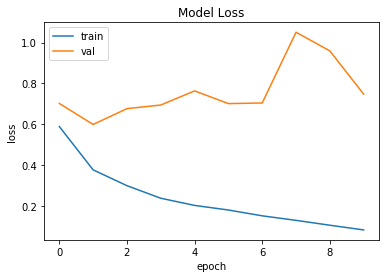

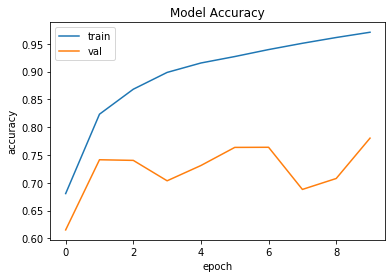

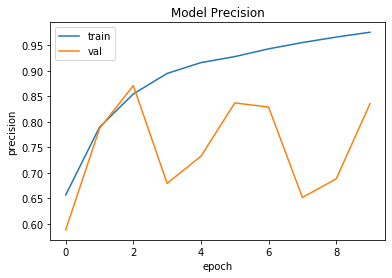

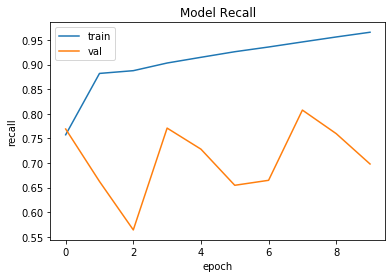

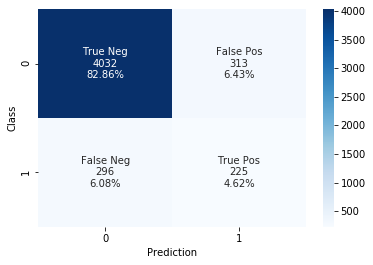

In [14]:
model_4cnn.save('/Crack_detection/Crack_detection/4CNN_model_011921.h5')

plot_loss(history_4cnn)
plot_accuracy(history_4cnn)
plot_precision(history_4cnn)
plot_recall(history_4cnn)

test_predict=model_4cnn.predict(pavements_test)
test_predict_classes=[1 if i>0.5 else 0 for i in test_predict]
plt.figure()
plot_cm(pavements_test.classes, test_predict_classes)

## CNN Model, 4 CNN layers w/ dropout=0.7 - no BatchNorm

In [4]:
model_4cnn_dp7=Sequential()

model_4cnn_dp7.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(img_height, img_width, 3)))
#model_4cnn.add(BatchNormalization())
model_4cnn_dp7.add(MaxPool2D(pool_size=(2,2)))

model_4cnn_dp7.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu'))
#model_3cnn.add(BatchNormalization())
model_4cnn_dp7.add(MaxPool2D(pool_size=(2,2)))

model_4cnn_dp7.add(Conv2D(64, kernel_size=(5,5), strides=(1,1), activation='relu'))
#model_4cnn.add(BatchNormalization())
model_4cnn_dp7.add(MaxPool2D(pool_size=(2,2)))

model_4cnn_dp7.add(Conv2D(128, kernel_size=(5,5), strides=(1,1), activation='relu'))
#model_4cnn.add(BatchNormalization())
model_4cnn_dp7.add(MaxPool2D(pool_size=(2,2)))

model_4cnn_dp7.add(Flatten())
model_4cnn_dp7.add(Dense(100, activation='relu'))
model_4cnn_dp7.add(Dropout(0.7))

model_4cnn_dp7.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_4cnn_dp7.build(input_shape=(img_height, img_width, 3))
model_4cnn_dp7.summary()

model_4cnn_dp7.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy', 'Recall', 'Precision'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 128)       2

In [5]:
history_4cnn_dp7=model_4cnn_dp7.fit(
pavements_train,
validation_data=pavements_val, 
epochs=10
)

Epoch 1/10
204/204 [==============================] - 668s 3s/step - loss: 0.6431 - accuracy: 0.6120 - recall: 0.7066 - precision: 0.5992 - val_loss: 0.6383 - val_accuracy: 0.6244 - val_recall: 0.7904 - val_precision: 0.5934
Epoch 2/10
204/204 [==============================] - 685s 3s/step - loss: 0.3482 - accuracy: 0.8501 - recall: 0.8813 - precision: 0.8323 - val_loss: 0.6809 - val_accuracy: 0.6863 - val_recall: 0.7824 - val_precision: 0.6563
Epoch 3/10
204/204 [==============================] - 724s 4s/step - loss: 0.2717 - accuracy: 0.8869 - recall: 0.9098 - precision: 0.8706 - val_loss: 0.7387 - val_accuracy: 0.6454 - val_recall: 0.7923 - val_precision: 0.6125
Epoch 4/10
204/204 [==============================] - 727s 4s/step - loss: 0.2351 - accuracy: 0.9009 - recall: 0.9166 - precision: 0.8894 - val_loss: 0.6853 - val_accuracy: 0.7227 - val_recall: 0.7702 - val_precision: 0.7035
Epoch 5/10
204/204 [==============================] - 726s 4s/step - loss: 0.2023 - accuracy: 0.9207

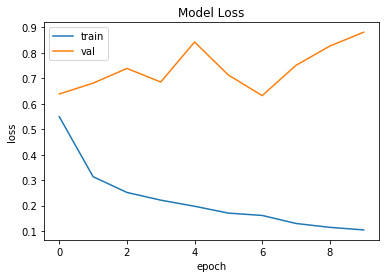

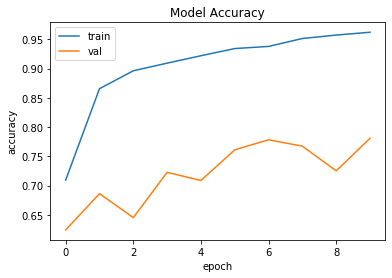

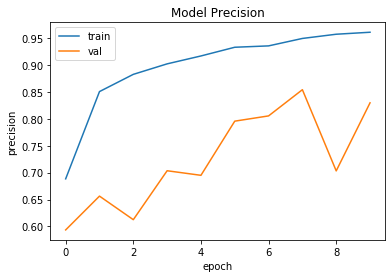

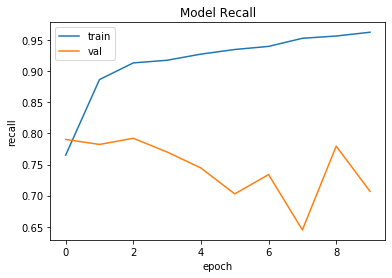

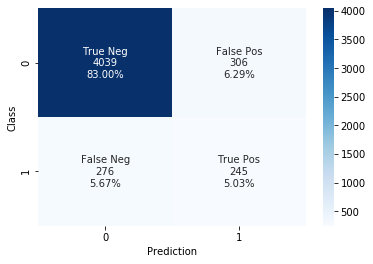

In [7]:
model_4cnn_dp7.save('/Crack_detection/Crack_detection/4CNN_dp7_model_011921.h5')

plot_loss(history_4cnn_dp7)
plot_accuracy(history_4cnn_dp7)
plot_precision(history_4cnn_dp7)
plot_recall(history_4cnn_dp7)

test_predict=model_4cnn_dp7.predict(pavements_test)
test_predict_classes=[1 if i>0.5 else 0 for i in test_predict]
plt.figure()
plot_cm(pavements_test.classes, test_predict_classes)

## CNN Model, 4 CNN layers w/ dropout=0.9 - no BatchNorm

In [8]:
model_4cnn_dp9=Sequential()

model_4cnn_dp9.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(img_height, img_width, 3)))
#model_4cnn.add(BatchNormalization())
model_4cnn_dp9.add(MaxPool2D(pool_size=(2,2)))

model_4cnn_dp9.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu'))
#model_3cnn.add(BatchNormalization())
model_4cnn_dp9.add(MaxPool2D(pool_size=(2,2)))

model_4cnn_dp9.add(Conv2D(64, kernel_size=(5,5), strides=(1,1), activation='relu'))
#model_4cnn.add(BatchNormalization())
model_4cnn_dp9.add(MaxPool2D(pool_size=(2,2)))

model_4cnn_dp9.add(Conv2D(128, kernel_size=(5,5), strides=(1,1), activation='relu'))
#model_4cnn.add(BatchNormalization())
model_4cnn_dp9.add(MaxPool2D(pool_size=(2,2)))

model_4cnn_dp9.add(Flatten())
model_4cnn_dp9.add(Dense(100, activation='relu'))
model_4cnn_dp9.add(Dropout(0.9))

model_4cnn_dp9.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_4cnn_dp9.build(input_shape=(img_height, img_width, 3))
model_4cnn_dp9.summary()

model_4cnn_dp9.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy', 'Recall', 'Precision'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 58, 58, 64)        51264     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 128)      

In [9]:
history_4cnn_dp9=model_4cnn_dp9.fit(
pavements_train,
validation_data=pavements_val, 
epochs=10
)

Epoch 1/10
204/204 [==============================] - 763s 4s/step - loss: 0.6677 - accuracy: 0.6086 - recall: 0.6253 - precision: 0.6147 - val_loss: 0.6370 - val_accuracy: 0.7019 - val_recall: 0.4615 - val_precision: 0.8892
Epoch 2/10
204/204 [==============================] - 729s 4s/step - loss: 0.4330 - accuracy: 0.8170 - recall: 0.8077 - precision: 0.8249 - val_loss: 0.6158 - val_accuracy: 0.7383 - val_recall: 0.6924 - val_precision: 0.7624
Epoch 3/10
204/204 [==============================] - 727s 4s/step - loss: 0.3415 - accuracy: 0.8635 - recall: 0.8524 - precision: 0.8728 - val_loss: 0.6473 - val_accuracy: 0.7480 - val_recall: 0.6352 - val_precision: 0.8205
Epoch 4/10
204/204 [==============================] - 742s 4s/step - loss: 0.3200 - accuracy: 0.8741 - recall: 0.8554 - precision: 0.8900 - val_loss: 0.6217 - val_accuracy: 0.7699 - val_recall: 0.5972 - val_precision: 0.9125
Epoch 5/10
204/204 [==============================] - 726s 4s/step - loss: 0.2945 - accuracy: 0.8921

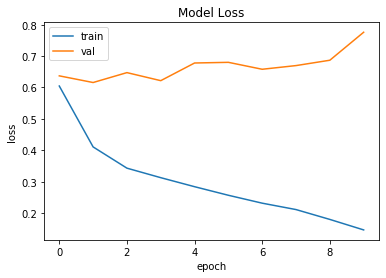

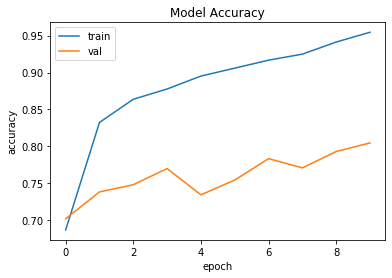

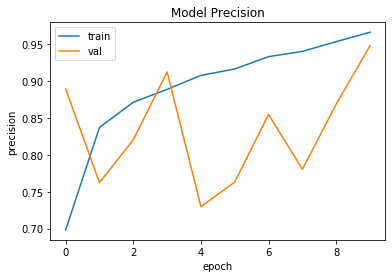

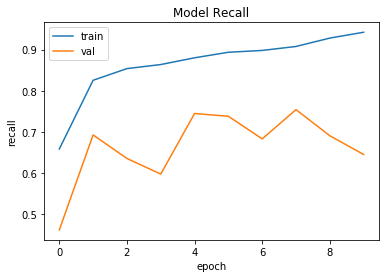

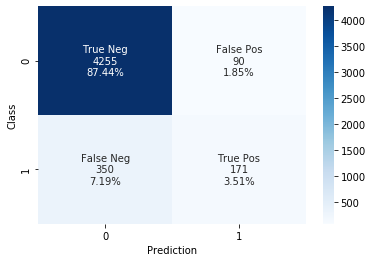

In [10]:
model_4cnn_dp9.save('/Crack_detection/Crack_detection/4CNN_dp9_model_011921.h5')

plot_loss(history_4cnn_dp9)
plot_accuracy(history_4cnn_dp9)
plot_precision(history_4cnn_dp9)
plot_recall(history_4cnn_dp9)

test_predict=model_4cnn_dp9.predict(pavements_test)
test_predict_classes=[1 if i>0.5 else 0 for i in test_predict]
plt.figure()
plot_cm(pavements_test.classes, test_predict_classes)

## CNN Model, 4 CNN layers (less filters) w/ dropout=0.9 - no BatchNorm

In [11]:
model_4cnn_dp9_sm=Sequential()

model_4cnn_dp9_sm.add(Conv2D(4, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(img_height, img_width, 3)))
#model_4cnn.add(BatchNormalization())
model_4cnn_dp9_sm.add(MaxPool2D(pool_size=(2,2)))

model_4cnn_dp9_sm.add(Conv2D(8, kernel_size=(3,3), strides=(1,1), activation='relu'))
#model_3cnn.add(BatchNormalization())
model_4cnn_dp9_sm.add(MaxPool2D(pool_size=(2,2)))

model_4cnn_dp9_sm.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation='relu'))
#model_4cnn.add(BatchNormalization())
model_4cnn_dp9_sm.add(MaxPool2D(pool_size=(2,2)))

model_4cnn_dp9_sm.add(Conv2D(32, kernel_size=(5,5), strides=(1,1), activation='relu'))
#model_4cnn.add(BatchNormalization())
model_4cnn_dp9_sm.add(MaxPool2D(pool_size=(2,2)))

model_4cnn_dp9_sm.add(Flatten())
model_4cnn_dp9_sm.add(Dense(100, activation='relu'))
model_4cnn_dp9_sm.add(Dropout(0.9))

model_4cnn_dp9_sm.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_4cnn_dp9_sm.build(input_shape=(img_height, img_width, 3))
model_4cnn_dp9_sm.summary()

model_4cnn_dp9_sm.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy', 'Recall', 'Precision'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 254, 254, 4)       112       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 127, 127, 4)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 125, 125, 8)       296       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 58, 58, 16)        3216      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 29, 29, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 25, 25, 32)       

In [12]:
history_4cnn_dp9_sm=model_4cnn_dp9_sm.fit(
pavements_train,
validation_data=pavements_val, 
epochs=10
)

Epoch 1/10
204/204 [==============================] - 316s 2s/step - loss: 0.6693 - accuracy: 0.5891 - recall: 0.6422 - precision: 0.5847 - val_loss: 0.7560 - val_accuracy: 0.5529 - val_recall: 0.7709 - val_precision: 0.5369
Epoch 2/10
204/204 [==============================] - 313s 2s/step - loss: 0.5266 - accuracy: 0.7429 - recall: 0.7814 - precision: 0.7246 - val_loss: 0.6667 - val_accuracy: 0.6543 - val_recall: 0.6476 - val_precision: 0.6565
Epoch 3/10
204/204 [==============================] - 314s 2s/step - loss: 0.4656 - accuracy: 0.7867 - recall: 0.8130 - precision: 0.7713 - val_loss: 0.6162 - val_accuracy: 0.7036 - val_recall: 0.6798 - val_precision: 0.7139
Epoch 4/10
204/204 [==============================] - 314s 2s/step - loss: 0.4045 - accuracy: 0.8238 - recall: 0.8349 - precision: 0.8191 - val_loss: 0.6184 - val_accuracy: 0.7100 - val_recall: 0.6630 - val_precision: 0.7318
Epoch 5/10
204/204 [==============================] - 313s 2s/step - loss: 0.3809 - accuracy: 0.8376

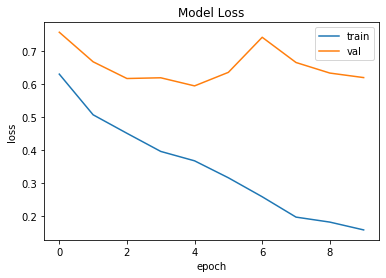

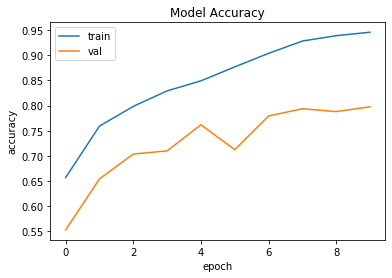

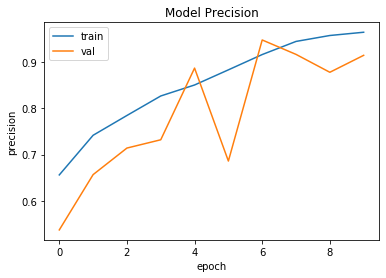

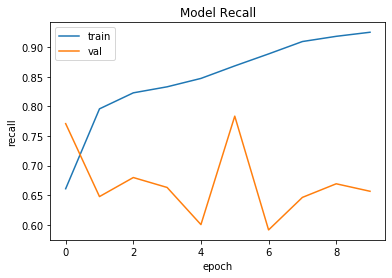

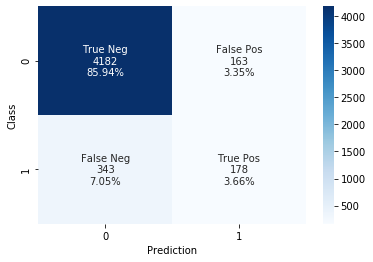

In [13]:
model_4cnn_dp9_sm.save('/Crack_detection/Crack_detection/4CNN_dp9_sm_model_011921.h5')

plot_loss(history_4cnn_dp9_sm)
plot_accuracy(history_4cnn_dp9_sm)
plot_precision(history_4cnn_dp9_sm)
plot_recall(history_4cnn_dp9_sm)

test_predict=model_4cnn_dp9_sm.predict(pavements_test)
test_predict_classes=[1 if i>0.5 else 0 for i in test_predict]
plt.figure()
plot_cm(pavements_test.classes, test_predict_classes)

## CNN Model, 4 CNN layers (less filters 2) w/ dropout=0.9 - no BatchNorm

In [4]:
model_4cnn_dp9_sm2=Sequential()

model_4cnn_dp9_sm2.add(Conv2D(4, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(img_height, img_width, 3)))
model_4cnn_dp9_sm2.add(MaxPool2D(pool_size=(2,2)))

model_4cnn_dp9_sm2.add(Conv2D(8, kernel_size=(3,3), strides=(1,1), activation='relu'))
model_4cnn_dp9_sm2.add(MaxPool2D(pool_size=(2,2)))

model_4cnn_dp9_sm2.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation='relu'))
model_4cnn_dp9_sm2.add(MaxPool2D(pool_size=(2,2)))

model_4cnn_dp9_sm2.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation='relu'))
model_4cnn_dp9_sm2.add(MaxPool2D(pool_size=(2,2)))

model_4cnn_dp9_sm2.add(Flatten())
model_4cnn_dp9_sm2.add(Dense(100, activation='relu'))
model_4cnn_dp9_sm2.add(Dropout(0.9))

model_4cnn_dp9_sm2.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_4cnn_dp9_sm2.build(input_shape=(img_height, img_width, 3))
model_4cnn_dp9_sm2.summary()

model_4cnn_dp9_sm2.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy', 'Recall', 'Precision'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 4)       112       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 4)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 8)       296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 16)        3216      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 16)        6

In [5]:
history_4cnn_dp9_sm2=model_4cnn_dp9_sm2.fit(
pavements_train,
validation_data=pavements_val, 
epochs=10
)

Epoch 1/10
204/204 [==============================] - 312s 2s/step - loss: 0.6682 - accuracy: 0.6026 - recall: 0.7090 - precision: 0.5867 - val_loss: 0.6272 - val_accuracy: 0.6469 - val_recall: 0.5809 - val_precision: 0.6694
Epoch 2/10
204/204 [==============================] - 291s 1s/step - loss: 0.4828 - accuracy: 0.7880 - recall: 0.7754 - precision: 0.7937 - val_loss: 0.6344 - val_accuracy: 0.6917 - val_recall: 0.5986 - val_precision: 0.7357
Epoch 3/10
204/204 [==============================] - 292s 1s/step - loss: 0.4101 - accuracy: 0.8255 - recall: 0.8204 - precision: 0.8285 - val_loss: 0.6580 - val_accuracy: 0.6597 - val_recall: 0.7260 - val_precision: 0.6411
Epoch 4/10
204/204 [==============================] - 291s 1s/step - loss: 0.3498 - accuracy: 0.8562 - recall: 0.8601 - precision: 0.8541 - val_loss: 0.6485 - val_accuracy: 0.7092 - val_recall: 0.4516 - val_precision: 0.9317
Epoch 5/10
204/204 [==============================] - 292s 1s/step - loss: 0.3108 - accuracy: 0.8816

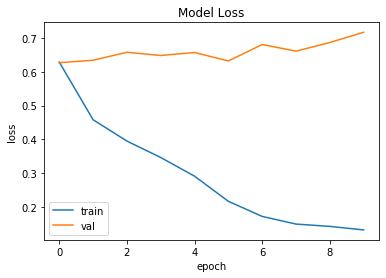

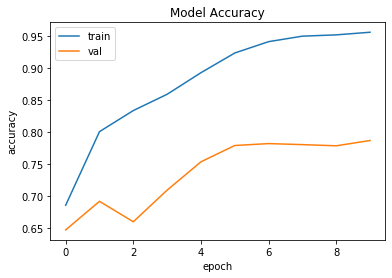

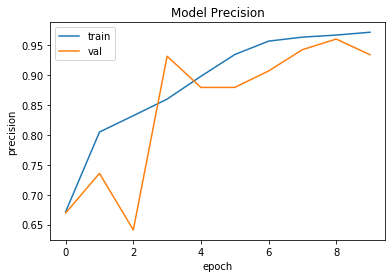

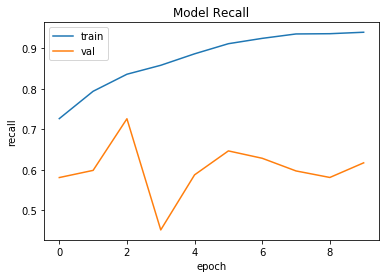

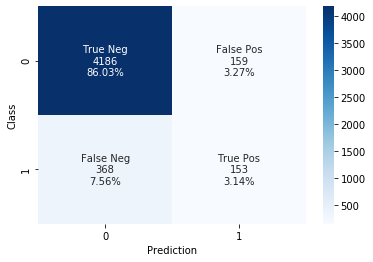

In [6]:
model_4cnn_dp9_sm2.save('/Crack_detection/Crack_detection/4CNN_dp9_sm_model_011921.h5')

plot_loss(history_4cnn_dp9_sm2)
plot_accuracy(history_4cnn_dp9_sm2)
plot_precision(history_4cnn_dp9_sm2)
plot_recall(history_4cnn_dp9_sm2)

test_predict=model_4cnn_dp9_sm2.predict(pavements_test)
test_predict_classes=[1 if i>0.5 else 0 for i in test_predict]
plt.figure()
plot_cm(pavements_test.classes, test_predict_classes)

## CNN Model, 5 CNN layers - no BatchNorm

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 58, 58, 64)        51264     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 128)      

NameError: name 'model_5cnn_dp7' is not defined

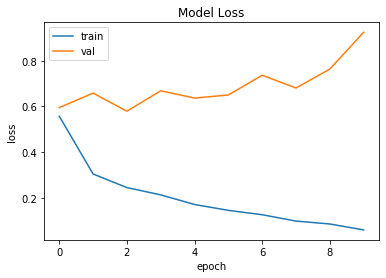

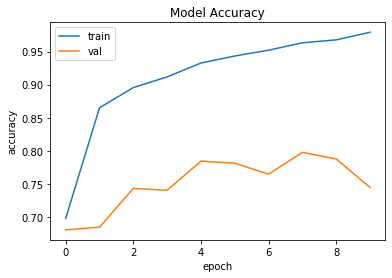

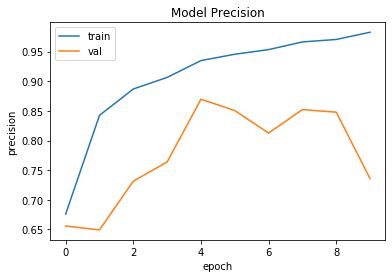

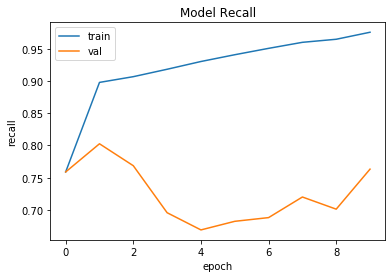

In [10]:
model_5cnn=Sequential()

model_5cnn.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(img_height, img_width, 3)))
model_5cnn.add(MaxPool2D(pool_size=(2,2)))

model_5cnn.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu'))
model_5cnn.add(MaxPool2D(pool_size=(2,2)))

model_5cnn.add(Conv2D(64, kernel_size=(5,5), strides=(1,1), activation='relu'))
model_5cnn.add(MaxPool2D(pool_size=(2,2)))

model_5cnn.add(Conv2D(128, kernel_size=(5,5), strides=(1,1), activation='relu'))
model_5cnn.add(MaxPool2D(pool_size=(2,2)))

model_5cnn.add(Conv2D(256, kernel_size=(5,5), strides=(1,1), activation='relu'))
model_5cnn.add(MaxPool2D(pool_size=(2,2)))

model_5cnn.add(Flatten())
model_5cnn.add(Dense(100, activation='relu'))

model_5cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_5cnn.build(input_shape=(img_height, img_width, 3))
model_5cnn.summary()

model_5cnn.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy', 'Recall', 'Precision'])

history_5cnn=model_5cnn.fit(
pavements_train,
validation_data=pavements_val, 
epochs=10
)

model_5cnn.save('/Crack_detection/Crack_detection/5CNN_model_012221.h5')

plot_loss(history_5cnn)
plot_accuracy(history_5cnn)
plot_precision(history_5cnn)
plot_recall(history_5cnn)

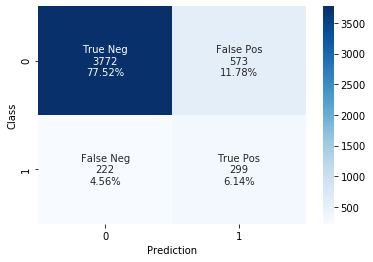

In [11]:
test_predict=model_5cnn.predict(pavements_test)
test_predict_classes=[1 if i>0.5 else 0 for i in test_predict]
plt.figure()
plot_cm(pavements_test.classes, test_predict_classes)

## CNN Model, 5 CNN layers w/ dropout=0.7 - no BatchNorm

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 128)       2

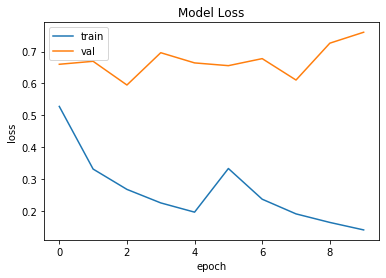

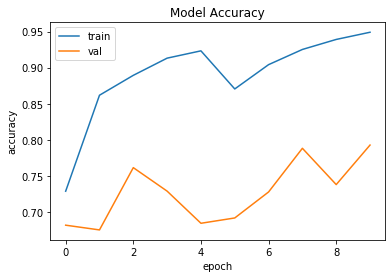

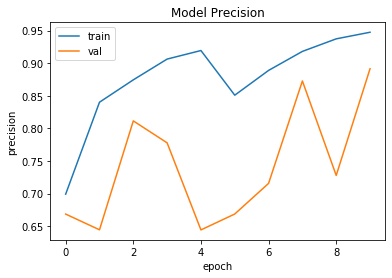

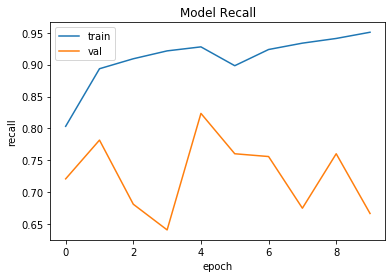

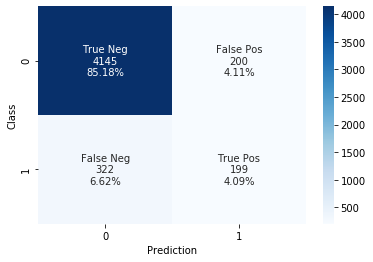

In [4]:
model_5cnn_dp7=Sequential()

model_5cnn_dp7.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(img_height, img_width, 3)))
model_5cnn_dp7.add(MaxPool2D(pool_size=(2,2)))

model_5cnn_dp7.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu'))
model_5cnn_dp7.add(MaxPool2D(pool_size=(2,2)))

model_5cnn_dp7.add(Conv2D(64, kernel_size=(5,5), strides=(1,1), activation='relu'))
model_5cnn_dp7.add(MaxPool2D(pool_size=(2,2)))

model_5cnn_dp7.add(Conv2D(128, kernel_size=(5,5), strides=(1,1), activation='relu'))
model_5cnn_dp7.add(MaxPool2D(pool_size=(2,2)))

model_5cnn_dp7.add(Conv2D(256, kernel_size=(5,5), strides=(1,1), activation='relu'))
model_5cnn_dp7.add(MaxPool2D(pool_size=(2,2)))

model_5cnn_dp7.add(Flatten())
model_5cnn_dp7.add(Dense(100, activation='relu'))
model_5cnn_dp7.add(Dropout(0.7))

model_5cnn_dp7.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_5cnn_dp7.build(input_shape=(img_height, img_width, 3))
model_5cnn_dp7.summary()

model_5cnn_dp7.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy', 'Recall', 'Precision'])

history_5cnn_dp7=model_5cnn_dp7.fit(
pavements_train,
validation_data=pavements_val, 
epochs=10
)

model_5cnn_dp7.save('/Crack_detection/Crack_detection/5CNN_dp7_model_012221.h5')

plot_loss(history_5cnn_dp7)
plot_accuracy(history_5cnn_dp7)
plot_precision(history_5cnn_dp7)
plot_recall(history_5cnn_dp7)

test_predict=model_5cnn_dp7.predict(pavements_test)
test_predict_classes=[1 if i>0.5 else 0 for i in test_predict]
plt.figure()
plot_cm(pavements_test.classes, test_predict_classes)

## CNN Model, 5 CNN layers, bigger filters - no BatchNorm

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 254, 254, 8)       224       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 127, 127, 8)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 125, 125, 16)      1168      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 58, 58, 32)        12832     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 25, 25, 64)       

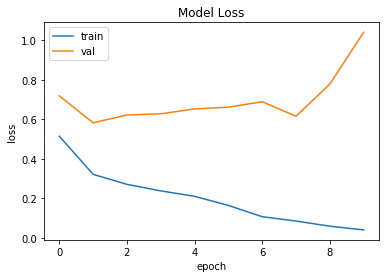

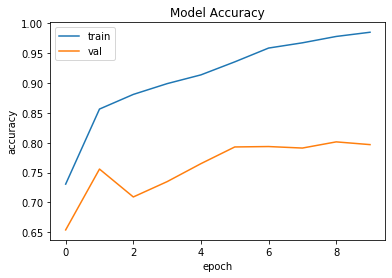

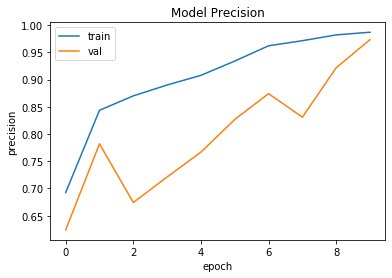

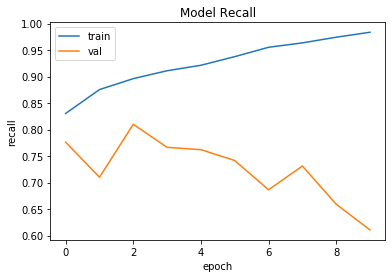

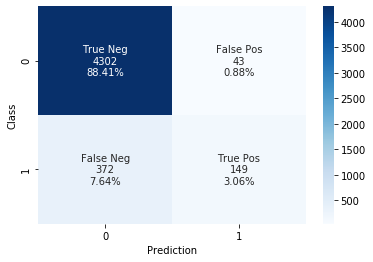

In [7]:
model_5cnn=Sequential()

model_5cnn.add(Conv2D(8, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(img_height, img_width, 3)))
model_5cnn.add(MaxPool2D(pool_size=(2,2)))

model_5cnn.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu'))
model_5cnn.add(MaxPool2D(pool_size=(2,2)))

model_5cnn.add(Conv2D(32, kernel_size=(5,5), strides=(1,1), activation='relu'))
model_5cnn.add(MaxPool2D(pool_size=(2,2)))

model_5cnn.add(Conv2D(64, kernel_size=(5,5), strides=(1,1), activation='relu'))
model_5cnn.add(MaxPool2D(pool_size=(2,2)))

model_5cnn.add(Conv2D(128, kernel_size=(5,5), strides=(1,1), activation='relu'))
model_5cnn.add(MaxPool2D(pool_size=(2,2)))


model_5cnn.add(Flatten())
model_5cnn.add(Dense(100, activation='relu'))

model_5cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_5cnn.build(input_shape=(img_height, img_width, 3))
model_5cnn.summary()

model_5cnn.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy', 'Recall', 'Precision'])

history_5cnn=model_5cnn.fit(
pavements_train,
validation_data=pavements_val, 
epochs=10
)

model_5cnn.save('/Crack_detection/Crack_detection/5CNN_less_filters_model_012221.h5')

plot_loss(history_5cnn)
plot_accuracy(history_5cnn)
plot_precision(history_5cnn)
plot_recall(history_5cnn)

test_predict=model_5cnn.predict(pavements_test)
test_predict_classes=[1 if i>0.5 else 0 for i in test_predict]
plt.figure()
plot_cm(pavements_test.classes, test_predict_classes)

## CNN Model, 5 CNN layers, 2 CNN layers back-to-back  - no BatchNorm

In [ ]:
model_3cnn_2=Sequential()

model_3cnn_2.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(img_height, img_width, 3), padding='same'))
model_3cnn_2.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
model_3cnn_2.add(MaxPool2D(pool_size=(2,2)))

model_3cnn_2.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
model_3cnn_2.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same'))
model_3cnn_2.add(MaxPool2D(pool_size=(2,2)))

model_3cnn_2.add(Conv2D(64, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same'))
model_3cnn_2.add(Conv2D(64, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same'))
model_3cnn_2.add(MaxPool2D(pool_size=(2,2)))

model_3cnn_2.add(Flatten())
model_3cnn_2.add(Dense(100, activation='relu'))

model_3cnn_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_3cnn_2.build(input_shape=(img_height, img_width, 3))
model_3cnn_2.summary()

model_3cnn_2.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy', 'Recall', 'Precision'])

history_3cnn_2=model_3cnn_2.fit(
pavements_train,
validation_data=pavements_val, 
epochs=10
)

model_3cnn_2.save('/Crack_detection/Crack_detection/3CNN_2_model_012221.h5')

plot_loss(history_3cnn_2)
plot_accuracy(history_3cnn_2)
plot_precision(history_3cnn_2)
plot_recall(history_3cnn_2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 256, 256, 16)      2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 64, 64, 64)       